# Relabeling CP output done on tiles named with DZI convention with overlap

It is a very hard thing to work with the information from images and a CSV at the same time when the only thing joining them is a global experiment key that is added manually. 

So Now I will load the CSVs into a  __[pandas data frame](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)__  0.23.4

This asumes the tiles are named with teh DZI tiling style meaning a tile named 2_3.png has a right neighbor 3_3.png
and a bottom neighbor called 2_4.png I need to know the neighbors so if there is no way to know them this notebook cant be ran.

There must also be a way to know the slide size, the overlap and have the access to cellprofiler output

In [9]:
import warnings
import numpy as np
import pandas as pd
import IPython.display
import matplotlib.pyplot as plt
import threading
import os.path
from skimage import io
import sys
import sqlite3
from matplotlib.patches import Circle
from notebooklibs import relabel
#import progressbar

warnings.filterwarnings('ignore')

In [2]:
#If you have your data as csv write the location here, other wise use a db below
csv_nuclei="/home/leslie/Documents/Uppsala/cellprofiler/output/exp-feb/1441-exp-febnuclei.csv"
csv_voronoi="/home/leslie/Documents/Uppsala/cellprofiler/output/exp-feb/1441-exp-febvoronoi.csv"
csv_image="/home/leslie/Documents/Uppsala/cellprofiler/output/exp-feb/1441-exp-febImage.csv"
csv_experiment="/home/leslie/Documents/Uppsala/cellprofiler/output/exp-feb/1441-exp-febExperiment.csv"

displayTables=True

#if you have dta as DB write location here
relabel.df_nuclei,relabel.df_voronoi,relabel.df_image,relabel.df_experiment=\
    relabel.loadDBIntoDataFrame("/home/leslie/Documents/Uppsala/cellprofiler/170315_161220_hippo_4_1/cellsegmentations/DefaultDB_2.db")



[0] MyExpt_2Per_Object
[1] MyExpt_2Per_Image
[2] Experiment
[3] sqlite_sequence
[4] Experiment_Properties
[5] MyExpt_2Per_Experiment
[6] MyExpt_2Per_RelationshipTypes
[7] MyExpt_2Per_Relationships
[8] _link_tables_MyExpt_2Per_Image_MyExpt_2Per_Object_
[9] _link_columns_MyExpt_2Per_Image_MyExpt_2Per_Object_
[10] MyExpt_2
[11] fluffy_n_tight
[13] None
Select table for primary objects
0
selected MyExpt_2Per_Object
Select table for Secondary objects
13
Select table for image data
1
selected MyExpt_2Per_Image
Select table for experiment data
4
selected Experiment_Properties


In [3]:
for x in relabel.df_nuclei.columns:
    print(x)

ImageNumber
ObjectNumber
Cytoplsms_Number_Object_Number
Cytoplsms_Location_Center_X
Cytoplsms_Location_Center_Y
Cytoplsms_Location_Center_Z
Cytoplsms_Parent_Nuclei
Nuclei_Number_Object_Number
Nuclei_AreaShape_Area
Nuclei_AreaShape_Center_X
Nuclei_AreaShape_Center_Y
Nuclei_AreaShape_Center_Z
Nuclei_AreaShape_Compactness
Nuclei_AreaShape_Eccentricity
Nuclei_AreaShape_EulerNumber
Nuclei_AreaShape_Extent
Nuclei_AreaShape_FormFactor
Nuclei_AreaShape_MajorAxisLength
Nuclei_AreaShape_MaxFeretDiameter
Nuclei_AreaShape_MaximumRadius
Nuclei_AreaShape_MeanRadius
Nuclei_AreaShape_MedianRadius
Nuclei_AreaShape_MinFeretDiameter
Nuclei_AreaShape_MinorAxisLength
Nuclei_AreaShape_Orientation
Nuclei_AreaShape_Perimeter
Nuclei_AreaShape_Solidity
Nuclei_Children_Cytoplsms_Count
Nuclei_Intensity_IntegratedIntensityEdge_DNA
Nuclei_Intensity_IntegratedIntensity_DNA
Nuclei_Intensity_LowerQuartileIntensity_DNA
Nuclei_Intensity_MADIntensity_DNA
Nuclei_Intensity_MassDisplacement_DNA
Nuclei_Intensity_MaxIntensity

In [9]:
#if csv load this instead
#relabel.df_nuclei.to_csv("/home/leslie/Documents/Uppsala/cellprofiler/newdata/newdata_2_initial.csv")

In [4]:
if relabel.df_nuclei is None:
    print("No nuclei /primary object database")
    print("Try from CSV? y/n ("+csv_nuclei+")")
    ans = input()
    ans=str(ans)
    if ans is "y":
        relabel.df_nuclei=loadIntoDataFrame(csv_nuclei)

#copy primary object df
print("rimary obejct copy")
relabel.df_nuclei_mod=relabel.df_nuclei.copy()
relabel.df_nuclei_mod.insert(0, "Global_Exp_ID", range(1, 1 + len(relabel.df_nuclei)))
#give additional temporal variable to the border objects
relabel.df_nuclei_mod.insert(0, "Matched", -1)
relabel.df_nuclei_mod.insert(0, "Erase", False)
relabel.df_nuclei_mod.insert(0, "Global_X", -1)
relabel.df_nuclei_mod.insert(0, "Global_Y", -1)
if (displayTables):
    IPython.display.display(relabel.df_nuclei_mod.iloc[0:5,:])


if relabel.df_voronoi is None:
    print("No voronoi / secondary object database")
    print("Try from CSV? y/n ("+csv_voronoi+")")
    ans = input()
    ans=str(ans)
    if ans is "y":
        relabel.df_voronoi=loadIntoDataFrame(csv_voronoi)
        if (displayTables):
            IPython.display.display(relabel.df_voronoi.iloc[5000:5005,:])
    


if relabel.df_image is None:
    print("No image database. You need one to continue")
    print("Try from CSV? y/n ("+csv_image+")")
    ans = input()
    ans=str(ans)
    if ans is "y":
        relabel.df_image=loadIntoDataFrame(csv_image)


total_rows = relabel.df_image.shape[0] 
print("Total tiles in experiment " +str(total_rows))

rimary obejct copy


,Global_Y,Global_X,Erase,Matched,Global_Exp_ID,ImageNumber,ObjectNumber,Cytoplsms_Number_Object_Number,Cytoplsms_Location_Center_X,Cytoplsms_Location_Center_Y,...,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_8_0,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_8_2,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_8_4,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_8_6,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_8_8,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_9_1,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_9_3,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_9_5,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_9_7,Nuclei_RadialDistribution_ZernikeMagnitude_CorrBlue_9_9
0,-1,-1,False,-1,1,5,1,1.0,1017.456698,28.209969,...,0.000274,0.000259,0.000712,0.000600,0.000374,0.000248,0.000200,0.000350,0.000286,0.000066
1,-1,-1,False,-1,2,5,2,2.0,1019.744848,74.646263,...,0.000557,0.000368,0.000827,0.001222,0.000419,0.000217,0.000517,0.000984,0.000610,0.000119
2,-1,-1,False,-1,3,5,3,3.0,1040.919494,131.683965,...,0.000606,0.000295,0.000458,0.000143,0.000373,0.000259,0.000274,0.000147,0.000293,0.000093
3,-1,-1,False,-1,4,5,4,4.0,1013.874945,149.025450,...,0.000110,0.000336,0.000422,0.000467,0.000371,0.000421,0.000255,0.000526,0.000173,0.000060
4,-1,-1,False,-1,5,5,5,5.0,1036.333333,270.720539,...,0.000112,0.000280,0.000456,0.000110,0.000049,0.000096,0.000042,0.000072,0.000175,0.000058


No voronoi / secondary object database
Try from CSV? y/n (/home/leslie/Documents/Uppsala/cellprofiler/output/exp-feb/1441-exp-febvoronoi.csv)
n
Total tiles in experiment 726


In [5]:
### This asumes the tiles are named with teh DZI tiling style meaning a tile named 2_3.png has a 
#right neighbor 3_3.png and a bottom neighbor called 3_2.png I need to know the neighbors so if 
#there is no way to know them this notebook cant be ran

#number of tiles along width, or columns
nbcols=33  #it is actually from 0 to 32

#number of tiles along height, or rows
nbrows=22   #it is actually from 0 to 21

#original tile size
origts=1024
origover=100
mygrace=1.5



#to check if an image has number in our experiment db
#df_image.loc[df_image[filenamecolumn]=="13_5.png"]
overlap=100
#location of tiles with labels
mainlocation="/home/leslie/Documents/Uppsala/cellprofiler/170315_161220_hippo_4_1/cellsegmentations/CellProfiler_regions/"
savelocation="/home/leslie/Documents/Uppsala/cellprofiler/170315_161220_hippo_4_1/cellsegmentations/relabeled/"
experimentname="MyExpt_2"



In [6]:

print("Ready to match all images")

print("filenamecolumn ",relabel.filenamecolumn)
print("po_x_location ",relabel.po_x_location)
print("po_y_location ",relabel.po_y_location)
print("tilewidth ",relabel.tilewidth)
print("tileheight ",relabel.tileheight)

for j in range(nbrows):
    for i in range(nbcols):
        relabel.matchObjectsInBorders(i,j,mainlocation,
            tilesize=origts,overlap=origover,
            grace=mygrace,filetypeorig=".png",filetypelabel=".tiff",
            suffix="_regs",draw=False)


relabel.df_nuclei_noterased=relabel.df_nuclei_mod.loc[relabel.df_nuclei_mod["Erase"]==False]
relabel.df_nuclei_mod.to_csv(savelocation+experimentname+"_mod2.2.csv", index=False)
relabel.df_nuclei_noterased.to_csv(savelocation+experimentname+"_noterased.csv", index=False)


print("done bye!")


Ready to match all images
filenamecolumn  Image_FileName_DNA
po_x_location  Nuclei_Location_Center_X
po_y_location  Nuclei_Location_Center_Y
tilewidth  Image_Width_DNA
tileheight  Image_Height_DNA
done bye!


# Experiments to verify correct marking for deletion

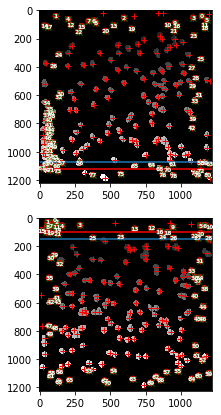

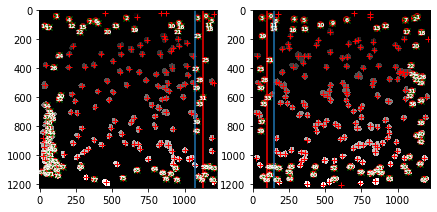

In [8]:
relabel.matchObjectsInBorders(16,11,mainlocation,
    tilesize=origts,overlap=origover,
    grace=mygrace,filetypeorig=".png",filetypelabel=".tiff",
    suffix="_regs",draw=True)

In [14]:
### This asumes the tiles are named with teh DZI tiling style meaning a tile named 2_3.png has a 
#right neighbor 3_3.png and a bottom neighbor called 3_2.png I need to know the neighbors so if 
#there is no way to know them this notebook cant be ran

#number of tiles along width, or columns
nbcols=33  #it is actually from 0 to 32

#number of tiles along height, or rows
nbrows=22   #it is actually from 0 to 21

#original tile size
origts=1024
origover=100
mygrace=1.5



#to check if an image has number in our experiment db
#df_image.loc[df_image[filenamecolumn]=="13_5.png"]
overlap=100
#location of tiles with labels
mainlocation="/home/leslie/Documents/Uppsala/cellprofiler/170315_161220_hippo_4_1/cellsegmentations/CellProfiler_regions/"
savelocation="/home/leslie/Documents/Uppsala/cellprofiler/170315_161220_hippo_4_1/cellsegmentations/relabeled/"
experimentname="MyExpt_2"

command="montage "

for j in range(2):
    for i in range(2):
        command+=str(i)+"_"+str(j)+"border_bordersTransparent.png "
    
command+="-background none -tile "+str(nbcols)+"x"+str(nbrows)+" -geometry +0+0 completeborders.png" 
print(command)

montage 0_0border_bordersTransparent.png 1_0border_bordersTransparent.png 0_1border_bordersTransparent.png 1_1border_bordersTransparent.png -background none -tile 33x22 -geometry +0+0 completeborders.png
